**This file provides all the commands required to simulate the circuit network example under different time-discretization schemes and coupling types. A simple approach is to extract the relevant part of the code to perform simulations with a specific coupling type and a desired discretization scheme.**

In [62]:
import time
import warnings
import math as m

import cvxpy as cp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from numpy import linalg
from numpy.linalg import matrix_rank
from scipy.integrate import solve_ivp
from scipy.linalg import block_diag

# Configure warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

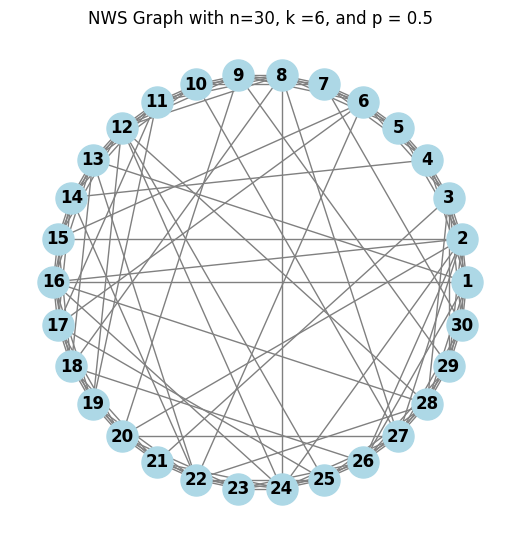

The second smallest eigenvalue of the Laplacian matrix: 2.9344
Number of edges: 129


In [63]:
# Construct a network in the form of Small World (Newman-Watts-Strogatz type)
n = 30
k = 6
p = 0.5
Graph = nx.newman_watts_strogatz_graph(n, k, p, seed=1)

#Create a mapping: 0→1, 1→2, ..., 9→10
mapping = {i: i + 1 for i in Graph.nodes()}
Graph = nx.relabel_nodes(Graph, mapping)

#Draw a network with nodes from 1 to n
pos = nx.circular_layout(Graph)
plt.figure(figsize=(5, 5))
nx.draw(Graph, pos, node_color='lightblue', node_size=500, edge_color='gray', with_labels=True, font_weight='bold')
plt.title(f'NWS Graph with n={n}, k ={k}, and p = {p}')
plt.show()

n_nodes = Graph.number_of_nodes()
m_edges = Graph.number_of_edges()

L = nx.laplacian_matrix(Graph).todense()

#Eigenvalue of L
eigvals = np.linalg.eigvals(L)
eigvals = np.sort(np.real(eigvals))

#Second smallest eigenvalue of L
lambda_2 = round(eigvals[1], 4)

print(f'The second smallest eigenvalue of the Laplacian matrix: {lambda_2}')
print(f'Number of edges: {m_edges}')

In [67]:
#Create a lexically oriented incidence matrix of the above Graph.
edges = [(min(u, v), max(u, v)) for u, v in Graph.edges()]

edges.sort()

num_edges = len(edges)
Theta = np.zeros((n, num_edges))

for e_idx, (u, v) in enumerate(edges):
    Theta[u - 1, e_idx] = 1
    Theta[v - 1, e_idx] = -1

In [68]:
###Create the agents
#Parameters in Matrix A(t)
mathbf_C = 2
mathbf_L = 1.5
mathbf_R = 1.5
alpha = 0.4
beta = 0.4

#AC Source
delta_1 = 4
delta_2 = 2
delta_3 = 1

#Matrix \bar{B}, and B
B_bar = np.array([[1], [0]])
B = np.kron(np.eye(n_nodes),B_bar)

#Matrix \bar{C}, and C
C_bar = np.array([[1/mathbf_C, 0]])
C = np.kron(np.eye(n_nodes), C_bar)

#Parameters for pertubations
para_gamma = np.zeros((n_nodes, 2))
for i in range(n_nodes):
    rng = np.random.default_rng(seed = 100 + i)
    para_gamma[i, 0] = rng.uniform(-0.4, 0.4)
    para_gamma[i, 1] = rng.uniform(-0.4, 0.4)

**Case 1:** Network using Semi-Backward Euler Scheme (SBES) and Set-Valued Couplings (SVC)

In [69]:
###Create all couplings in the form of Lemma 4
#Matrix W'
Wij = 15
W = block_diag(*[Wij]*m_edges)

#Matrix H'
Hij = np.array([[3, -2]])
H = block_diag(*[Hij]*m_edges)

#Matrix N'
Nij = np.array([[3], [-2]])
N = block_diag(*[Nij]*m_edges)

#Matrix M'
Mij = np.array([[1,2],[2,4]])
M = block_diag(*[Mij]*m_edges)

#Vector r'
rij = np.array([[-5],[-10]])
r = np.vstack([rij for _ in range(m_edges)])

#Matrix Gamma'
Gamma = M

In [79]:
###Create parameters for using Algorithm 1
#Initial state x0
rng_x0 = np.random.default_rng(seed=1)
x0 = rng_x0.uniform(-1, 1, (2*n_nodes, 1))*5

#Time-step h
h = 0.01

#R, R^{-1}
R = (1/np.sqrt(mathbf_C))*np.eye(2*n_nodes)
Rinv = np.linalg.inv(R)

#Matrix in step 1
Matrix_1 = B@Theta@W@Theta.T@C

#Matrix in step 2
G = N@Theta.T@C@Rinv
Matrix_2 = Gamma + h*G@G.T

#Matrix in step 3
Matrix_3 = Theta@W@Theta.T@C
Matrix_4 = Theta@H

**Strategy 1:** Solving the LCPs at Step 2 of Algorithm 1, using CVXPY library, OSQP Solver.

In [80]:
#Number of iterations
n_inter = 2000

X = np.zeros((2*n_nodes, n_inter))     #State
T = []                                 #Time
U = np.zeros((n_nodes, n_inter))       #Input

xk = x0
step_times = []
total_start = time.perf_counter()

#Optimal variable
x_bar = cp.Variable((2*m_edges,1))
h_z = np.zeros((2*m_edges,1))

zk_bar_para = cp.Parameter((G.shape[1], 1))

#Objective function
obj = cp.quad_form(x_bar, cp.psd_wrap(Matrix_2)) + 2*(r + G@zk_bar_para).T@x_bar

#Constraint
constraints = [x_bar >= 0]

problem = cp.Problem(cp.Minimize(obj), constraints)
for k in range(0,n_inter):
  t = k*h
  step_start = time.perf_counter()

  #Matrix A(t)
  Lt = mathbf_L + alpha*np.sin(0.2*t+2)*np.cos(3*t-1)
  Rt = mathbf_R + beta*np.sin(2*t-3)*np.cos(-4*t+0.1)
  dL = alpha*(0.2*np.cos(0.2*t+2)*np.cos(3*t-1) - 3*np.sin(0.2*t+2)*np.sin(3*t-1))
  A_bar = np.array([[0, -1], [1/(mathbf_C*Lt), -(Rt+dL)/Lt]])
  At = np.kron(np.eye(n_nodes), A_bar)

  #Compute AC source, zk_bar
  I_s = delta_1 * np.sin(delta_2 * t + delta_3) * np.ones((n_nodes, 1))
  Fnom = At@xk + B@I_s
  zk_bar = R@(xk + h*Fnom - h*Matrix_1@xk)

  x_bar.value = h_z
  zk_bar_para.value = zk_bar
  #problem.solve(solver=cp.OSQP, eps_abs=1e-1, eps_rel=1e-1, max_iter=5, warm_start=True)
  #problem.solve(solver=cp.OSQP, eps_abs=1e-10, eps_rel=1e-10, max_iter=10000, warm_start=True)
  problem.solve(solver=cp.OSQP, warm_start=True)

  #Result of the control input u_k
  h_z = x_bar.value
  uk = -Matrix_3@xk + Matrix_4@h_z

  step_end = time.perf_counter()
  elapsed = step_end - step_start
  step_times.append(elapsed)

  #Update X, T, U
  X[:,k] = xk[:,0]
  T = np.append(T,t)
  U[:, k] = uk[:,0]

  #Pertubations \bar{xi}
  xi_bar = np.zeros((n_nodes,1))
  for i in range(0, n_nodes):
    xi_bar[i,0] = para_gamma[i,0]*np.sin(0.4*t + xk[i,0]-2*xk[i+1,0]) + para_gamma[i,1]*np.cos(-2*t + 0.2*xk[i+1,0])

  #Update x_k (i.e. compute x_{k+1})
  xk = xk + h*(Fnom + B@uk) + h*B@xi_bar

total_end = time.perf_counter()
print(f"Total execution time: {total_end - total_start:.6f} seconds")

Total execution time: 9.360146 seconds


Minimum value: 0.0039966829999684705
Maximum value: 0.018391720000181522
Average: 0.004453448905003825
99.9th percentile: 0.013189771155858732


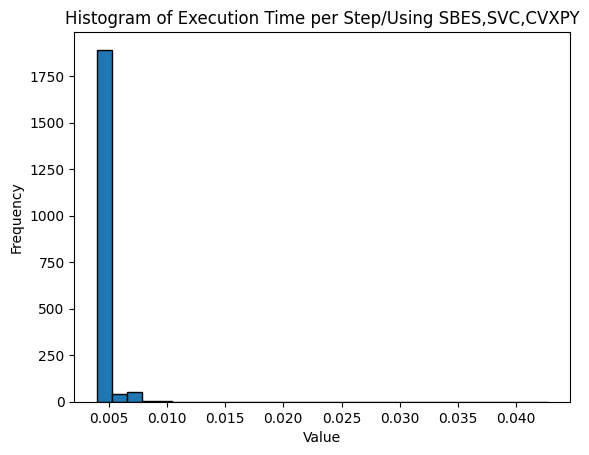

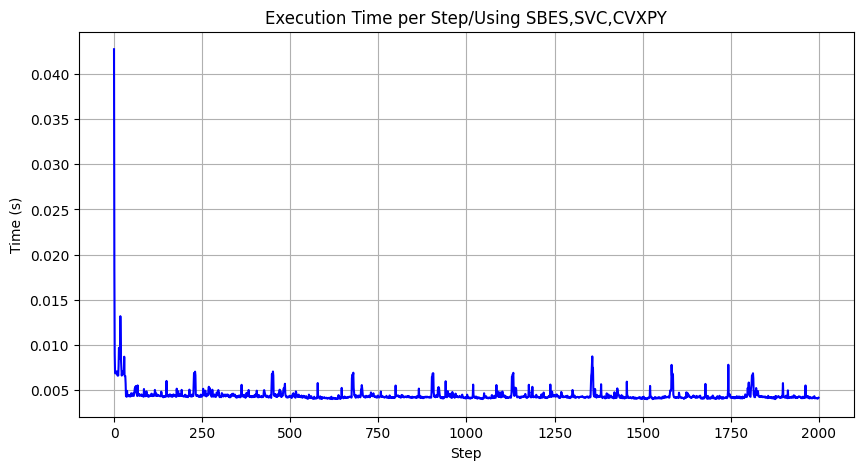

In [81]:
#Basic statistics
print("Minimum value:", np.min(step_times))
print("Maximum value:", np.max(step_times[1:]))
print("Average:", np.mean(step_times))
print("99.9th percentile:", np.percentile(step_times, 99.9))

plt.hist(step_times, bins=30, edgecolor='black')
plt.title("Histogram of Execution Time per Step/Using SBES,SVC,CVXPY")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Plot the execution time of each step
plt.figure(figsize=(10, 5))
plt.plot(range(n_inter), step_times, color='blue')
plt.xlabel('Step')
plt.ylabel('Time (s)')
plt.title('Execution Time per Step/Using SBES,SVC,CVXPY')
plt.grid(True)
plt.show()

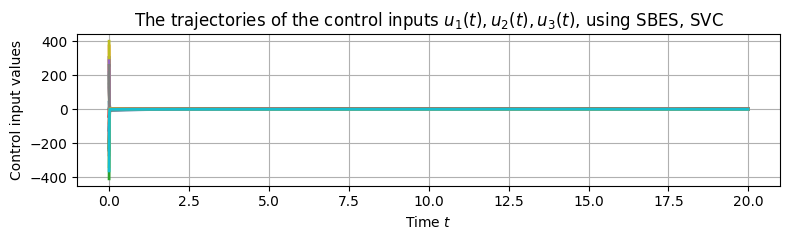

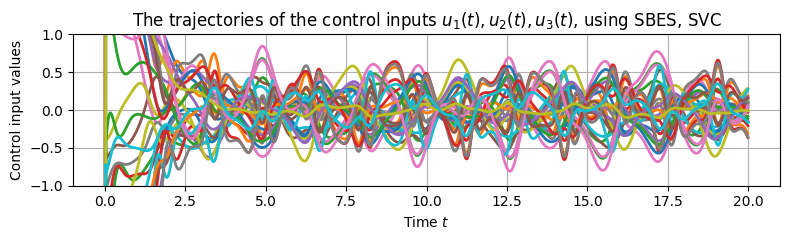

/tmp/ipython-input-3196930912.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


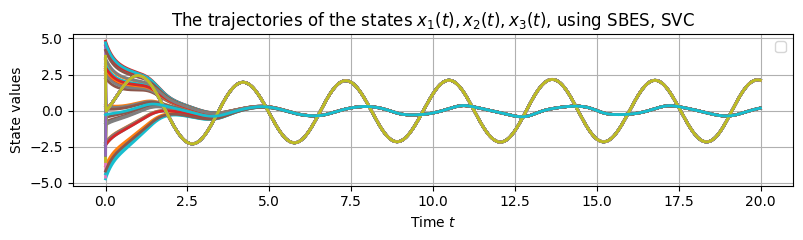

In [82]:
#Plot the input u(t)
plt.figure(figsize=(8, 2.5))
for i in range(n_nodes):
  plt.plot(T, U[i,:], linewidth=2)

plt.xlabel('Time $t$')
plt.ylabel('Control input values')
plt.title('The trajectories of the control inputs $u_1(t), u_2(t), u_{3}(t)$, using SBES, SVC')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 2.5))
for i in range(n_nodes):
  plt.plot(T, U[i,:], linewidth=2)

plt.xlabel('Time $t$')
plt.ylabel('Control input values')
plt.title('The trajectories of the control inputs $u_1(t), u_2(t), u_{3}(t)$, using SBES, SVC')
plt.grid(True)
plt.ylim(-1,1)
plt.tight_layout()
plt.show()

#Plot the state x(t)
plt.figure(figsize=(8, 2.5))
for i in range(0,2*n_nodes,2):
  plt.plot(T, X[i,:], linewidth=2)
  plt.plot(T, X[i+1,:], linewidth=2)

plt.xlabel('Time $t$')
plt.ylabel('State values')
plt.title('The trajectories of the states $x_1(t), x_2(t), x_{3}(t)$, using SBES, SVC')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

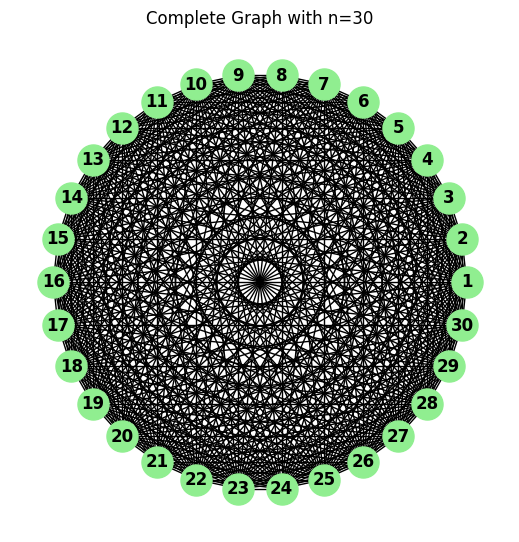

In [83]:
###Compute Error state e(t) = (Theta_c.T \otimes I_2)x(t) and its norm.
Graph_complete = nx.complete_graph(n)

mapping_complete = {i: i + 1 for i in Graph_complete.nodes()}
Graph_complete = nx.relabel_nodes(Graph_complete, mapping_complete)

pos = nx.circular_layout(Graph_complete)
plt.figure(figsize=(5, 5))
nx.draw(Graph_complete, pos, node_color='lightgreen', node_size=500, edge_color='black', with_labels=True, font_weight='bold')
plt.title(f'Complete Graph with n={n}')
plt.show()

#Create an oriented incidence matrix of the complete Graph corresponding to the above Graph.
edges_complete = []
for u, v in Graph_complete.edges():
  if u > v:
    edges_complete.append((u, v))
  else:
    edges_complete.append((v, u))

num_edges_complete = len(edges_complete)
Theta_c = np.zeros((n, num_edges_complete))

for e_idx, (u, v) in enumerate(edges_complete):
    # Subtract 1 from u and v to adjust for 0-based indexing in NumPy
    Theta_c[u - 1, e_idx] = -1
    Theta_c[v - 1, e_idx] = +1

E = np.kron(Theta_c.T, np.eye(2)) @ X  # shape: (time_steps, new_dim)
e = np.linalg.norm(E, axis=0)

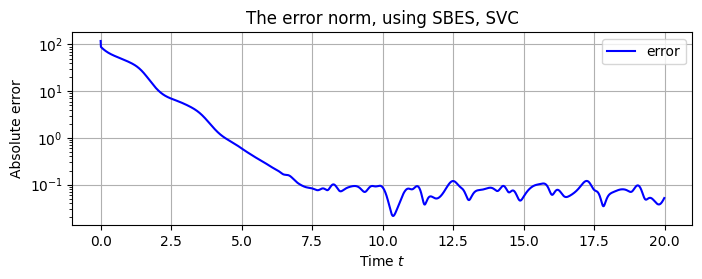

In [84]:
###Draw the error norm
plt.figure(figsize=(8, 2.5))
plt.plot(T, e, label="error", color='blue')

plt.yscale('log')
plt.xlabel('Time $t$')
plt.ylabel('Absolute error')
plt.title('The error norm, using SBES, SVC')
plt.legend()
plt.grid()
plt.show()

**Strategy 2:** Solving the LCPs at Step 2 of Algorithm 1, using LCP solver (Lemke's pivoting method).

In [85]:
def LCPSolve(M, q, pivtol=1e-8, maxits=1e3):
    rayTerm = False
    loopcount = 0

    q = np.asarray(q).flatten()
    dimen = M.shape[0]

    if q.shape[0] != dimen:
        raise ValueError("Matrix M and vector q sizes are incompatible")

    q = q.reshape(-1, 1)  # Ensure q is a column vector (dimen x 1)

    if (q >= 0.).all():  # Check trivial solution: if q >= 0, then w = q and z = 0
        w = q.flatten()  # Flatten the result
        z = np.zeros_like(q).flatten()  # Create a zero array with the same shape as q and flatten it
        retcode = 0.
    else:
        # Create initial tableau
        # Concatenate eye(dimen), -M, -ones((dimen, 1)), and q (already dimen x 1)
        tableau = np.hstack([np.eye(dimen), -M, -np.ones((dimen, 1)), q])

        basis = list(range(dimen))  # basis contains the set of COLUMN indices in the tableau
        locat = np.argmin(tableau[:, 2*dimen+1])  # row of the smallest element in the last column
        basis[locat] = 2*dimen  # replace that choice by artificial variable (column index 2*dimen)
        cand = locat + dimen    # Column index of complement variable for the variable leaving the basis

        # Perform initial pivot step to remove the artificial variable from the basis
        pivot = tableau[locat, :] / tableau[locat, 2*dimen]
        tableau -= tableau[:, 2*dimen:2*dimen+1] * pivot
        tableau[locat, :] = pivot

        # Perform complementary pivot with iteration limit to avoid infinite loops
        oldDivideErr = np.seterr(divide='ignore')['divide']  # suppress divide by zero warnings
        while np.amax(basis) == 2*dimen and loopcount < maxits:
            loopcount += 1
            eMs = tableau[:, cand]  # candidate variable column

            # Mask for elements less than or equal to the pivot tolerance
            missmask = eMs <= 0

            # Compute ratios for pivot selection
            quots = np.full(dimen, np.inf)  # initialize with infinity
            valid_mask = ~missmask & (np.abs(eMs) > pivtol)
            quots[valid_mask] = tableau[valid_mask, 2*dimen+1] / eMs[valid_mask]

            locat = np.argmin(quots)  # position of smallest ratio

            # Check if a valid pivot exists
            if np.isfinite(quots[locat]) and abs(eMs[locat]) > pivtol:
                # Update tableau
                pivot = tableau[locat, :] / tableau[locat, cand]
                tableau -= tableau[:, cand:cand+1] * pivot
                tableau[locat, :] = pivot

                oldVar = basis[locat]  # variable leaving the basis
                basis[locat] = cand    # variable entering the basis

                # Update candidate variable
                if oldVar >= dimen:
                    cand = oldVar - dimen
                else:
                    cand = oldVar + dimen
            else:
                rayTerm = True  # termination due to ray condition (no positive pivot found)
                break
        np.seterr(divide=oldDivideErr)  # restore numpy divide error handling

        # Return solution
        vars = np.zeros(2 * dimen + 1)
        for i, b_idx in enumerate(basis):
            if 0 <= b_idx < len(vars):
                vars[b_idx] = tableau[i, 2*dimen+1]

        w = vars[:dimen].flatten()
        z = vars[dimen:2*dimen].flatten()
        retcode = vars[2*dimen]

    # Return status
    if rayTerm:
        retcode = (2, retcode, loopcount)  # termination due to ray
    else:
        retcode = (1, retcode, loopcount)  # success

    return w, z, retcode

In [90]:
###Create parameters for using Algorithm 1
#Initial state x0
rng_x0 = np.random.default_rng(seed=1)
x0 = rng_x0.uniform(-1, 1, (2*n_nodes, 1))*5

#Time-step h
h = 0.01

#R, R^{-1}
R = (1/np.sqrt(mathbf_C))*np.eye(2*n_nodes)
Rinv = np.linalg.inv(R)

#Matrix in step 1
Matrix_1 = B@Theta@W@Theta.T@C

#Matrix in step 2
G = N@Theta.T@C@Rinv
Matrix_2 = Gamma + h*G@G.T

#Matrix in step 3
Matrix_3 = Theta@W@Theta.T@C
Matrix_4 = Theta@H

In [91]:
#Number of iterations
n_inter = 2000

X = np.zeros((2*n_nodes, n_inter))     #State
T = []                                 #Time
U = np.zeros((n_nodes, n_inter))       #Input

xk = x0
step_times = []
total_start = time.perf_counter()

for k in range(0,n_inter):
  t = k*h
  step_start = time.perf_counter()

  #Matrix A(t)
  Lt = mathbf_L + alpha*np.sin(0.2*t+2)*np.cos(3*t-1)
  Rt = mathbf_R + beta*np.sin(2*t-3)*np.cos(-4*t+0.1)
  dL = alpha*(0.2*np.cos(0.2*t+2)*np.cos(3*t-1) - 3*np.sin(0.2*t+2)*np.sin(3*t-1))
  A_bar = np.array([[0, -1], [1/(mathbf_C*Lt), -(Rt+dL)/Lt]])
  At = np.kron(np.eye(n_nodes), A_bar)

  #Compute AC source, zk_bar
  I_s = delta_1 * np.sin(delta_2 * t + delta_3) * np.ones((n_nodes, 1))
  Fnom = At@xk + B@I_s
  zk_bar = R@(xk + h*Fnom - h*Matrix_1@xk)

  q = G@zk_bar + r
  l = LCPSolve(Matrix_2, q)[1].reshape(2*m_edges,1)

  #Result of the control input u_k
  uk = -Matrix_3@xk + Matrix_4@l

  step_end = time.perf_counter()
  elapsed = step_end - step_start
  step_times.append(elapsed)

  #Update X, T, U
  X[:,k] = xk[:,0]
  T = np.append(T,t)
  U[:, k] = uk[:,0]

  #Pertubations \bar{xi}
  xi_bar = np.zeros((n_nodes,1))
  for i in range(0, n_nodes):
    xi_bar[i,0] = para_gamma[i,0]*np.sin(0.4*t + xk[i,0]-2*xk[i+1,0]) + para_gamma[i,1]*np.cos(-2*t + 0.2*xk[i+1,0])

  #Update x_k (i.e. compute x_{k+1})
  xk = xk + h*(Fnom + B@uk) + h*B@xi_bar

total_end = time.perf_counter()
print(f"Total execution time: {total_end - total_start:.6f} seconds")

Total execution time: 397.746580 seconds


Minimum value: 0.07514749599977222
Maximum value: 0.9409776600004989
Average: 0.19861276200651856
99.9th percentile: 0.5541391014183054


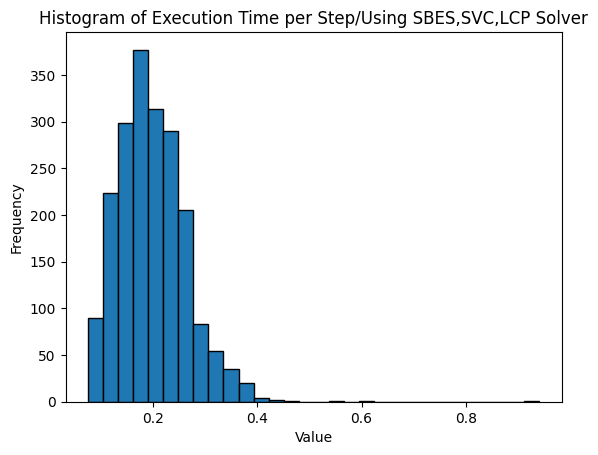

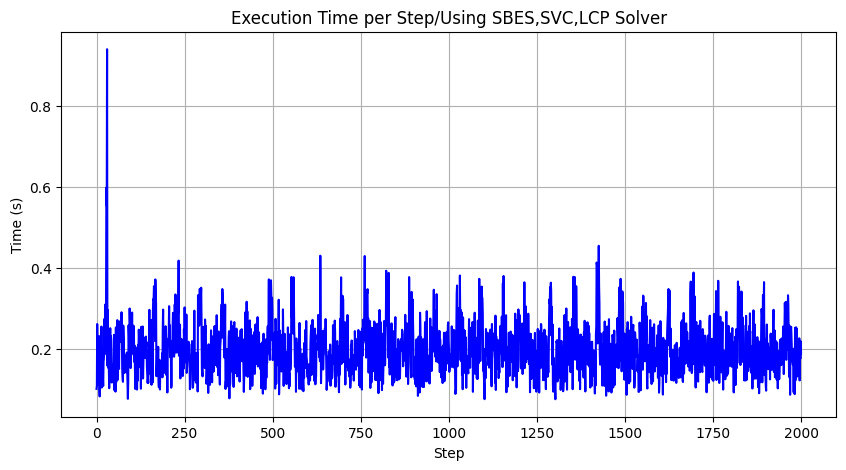

In [92]:
#Basic statistics
print("Minimum value:", np.min(step_times))
print("Maximum value:", np.max(step_times[1:]))
print("Average:", np.mean(step_times))
print("99.9th percentile:", np.percentile(step_times, 99.9))

plt.hist(step_times, bins=30, edgecolor='black')
plt.title("Histogram of Execution Time per Step/Using SBES,SVC,LCP Solver")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Plot the execution time of each step
plt.figure(figsize=(10, 5))
plt.plot(range(n_inter), step_times, color='blue')
plt.xlabel('Step')
plt.ylabel('Time (s)')
plt.title('Execution Time per Step/Using SBES,SVC,LCP Solver')
plt.grid(True)
plt.show()

**Case 2:** Network using Forward Euler Scheme (FES) and Set-Valued Couplings (SVC)

In [93]:
###Create parameters for using scheme (48)-(49)
#Initial state x0
rng_x0 = np.random.default_rng(seed=1)
x0 = rng_x0.uniform(-1, 1, (2*n_nodes, 1))*5

#Time-step h
h = 0.01

#R, R^{-1}
R = (1/np.sqrt(mathbf_C))*np.eye(2*n_nodes)
Rinv = np.linalg.inv(R)

#Matrix in (48)
Matrix_1 = Theta@W@Theta.T@C
Matrix_2 = Theta@H

#Matrix in (49)
Matrix_3 = N@Theta.T@C

In [94]:
#Number of iterations
n_inter = 2000

X = np.zeros((2*n_nodes, n_inter))     #State
T = []                                 #Time
U = np.zeros((n_nodes, n_inter))       #Input

xk = x0

#Optimal variable
x_bar = cp.Variable((2*m_edges,1))
h_z = np.zeros((2*m_edges,1))

q = cp.Parameter((r.shape[0], 1))
#Objective function
obj = cp.quad_form(x_bar, cp.psd_wrap(Gamma)) + 2*q.T@x_bar

#Constraint
constraints = [x_bar >= 0]

problem = cp.Problem(cp.Minimize(obj), constraints)
for k in range(0,n_inter):
  t = k*h
  #Matrix A(t)
  Lt = mathbf_L + alpha*np.sin(0.2*t+2)*np.cos(3*t-1)
  Rt = mathbf_R + beta*np.sin(2*t-3)*np.cos(-4*t+0.1)
  dL = alpha*(0.2*np.cos(0.2*t+2)*np.cos(3*t-1) - 3*np.sin(0.2*t+2)*np.sin(3*t-1))
  A_bar = np.array([[0, -1], [1/(mathbf_C*Lt), -(Rt+dL)/Lt]])
  At = np.kron(np.eye(n_nodes), A_bar)

  #Compute AC source, zk_bar
  I_s = delta_1 * np.sin(delta_2 * t + delta_3) * np.ones((n_nodes, 1))
  Fnom = At@xk + B@I_s
  q_val = Matrix_3@xk + r

  #Solution of LCP (49)
  x_bar.value = h_z
  q.value = q_val
  problem.solve(solver=cp.OSQP, eps_abs=1e-10, eps_rel=1e-10, max_iter=100000, warm_start=True)
  l = x_bar.value

  #Result of the control input u_k
  uk = -Matrix_1@xk + Matrix_2@l

  #Update X, T, U, Y, and Per
  X[:,k] = xk[:,0]
  T = np.append(T,t)
  U[:, k] = uk[:,0]

  #Pertubations \bar{xi}
  xi_bar = np.zeros((n_nodes,1))
  for i in range(0, n_nodes):
      xi_bar[i,0] = para_gamma[i,0]*np.sin(0.4*t + xk[i,0]-2*xk[i+1,0]) + para_gamma[i,1]*np.cos(-2*t + 0.2*xk[i+1,0])

  #Update x_k (i.e. compute x_{k+1})
  xk = xk + h*(Fnom + B@uk) + h*B@xi_bar

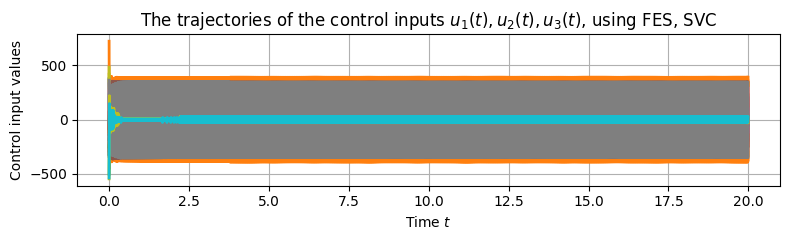

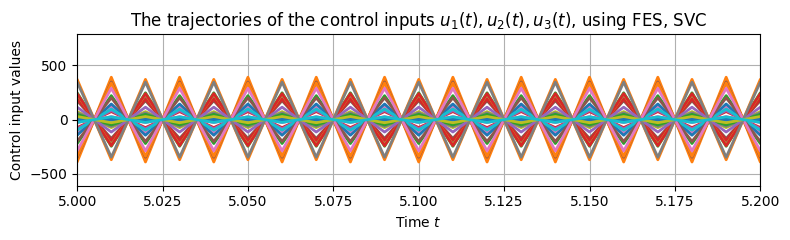

In [95]:
#Plot the input u(t)
plt.figure(figsize=(8, 2.5))
for i in range(n_nodes):
  plt.plot(T, U[i,:], linewidth=2)

plt.xlabel('Time $t$')
plt.ylabel('Control input values')
plt.title('The trajectories of the control inputs $u_1(t), u_2(t), u_{3}(t)$, using FES, SVC')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 2.5))
for i in range(n_nodes):
  plt.plot(T, U[i,:], linewidth=2)

plt.xlabel('Time $t$')
plt.ylabel('Control input values')
plt.title('The trajectories of the control inputs $u_1(t), u_2(t), u_{3}(t)$, using FES, SVC')
plt.grid(True)
plt.xlim(5, 5.2)
plt.tight_layout()
plt.show()

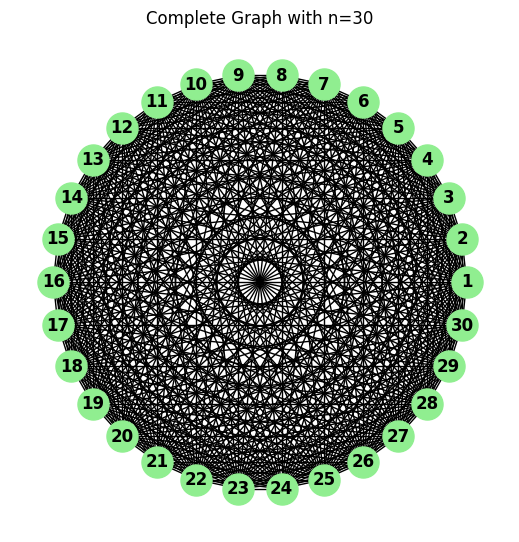

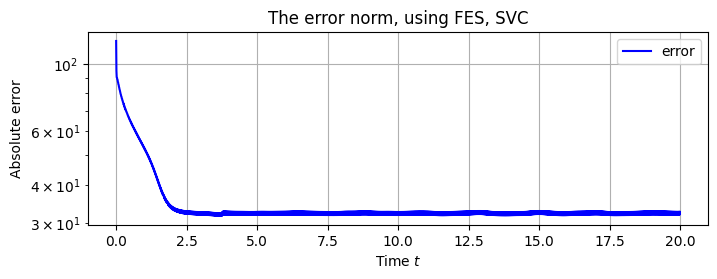

In [96]:
###Compute Error state e(t) = (Theta_c.T \otimes I_2)x(t) and its norm.
Graph_complete = nx.complete_graph(n)

mapping_complete = {i: i + 1 for i in Graph_complete.nodes()}
Graph_complete = nx.relabel_nodes(Graph_complete, mapping_complete)

pos = nx.circular_layout(Graph_complete)
plt.figure(figsize=(5, 5))
nx.draw(Graph_complete, pos, node_color='lightgreen', node_size=500, edge_color='black', with_labels=True, font_weight='bold')
plt.title(f'Complete Graph with n={n}')
plt.show()

#Create an oriented incidence matrix of the complete Graph corresponding to the above Graph.
edges_complete = []
for u, v in Graph_complete.edges():
  if u > v:
    edges_complete.append((u, v))
  else:
    edges_complete.append((v, u))

num_edges_complete = len(edges_complete)
Theta_c = np.zeros((n, num_edges_complete))

for e_idx, (u, v) in enumerate(edges_complete):
    # Subtract 1 from u and v to adjust for 0-based indexing in NumPy
    Theta_c[u - 1, e_idx] = -1
    Theta_c[v - 1, e_idx] = +1

E = np.kron(Theta_c.T, np.eye(2)) @ X  # shape: (time_steps, new_dim)
e = np.linalg.norm(E, axis=0)

###Draw the error norm
plt.figure(figsize=(8, 2.5))
plt.plot(T, e, label="error", color='blue')

plt.yscale('log')
plt.xlabel('Time $t$')
plt.ylabel('Absolute error')
plt.title('The error norm, using FES, SVC')
plt.legend()
plt.grid()
plt.show()

**Case 3:** Network using Forward Euler Scheme (FES) and Purely Linear Couplings (LC)

In [97]:
###Create all couplings in the form of Lemma 4
#Matrix W'
Wij = 15
W = block_diag(*[Wij]*m_edges)

#Matrix H'
Hij = 0
H = block_diag(*[Hij]*m_edges)

#Matrix N'
Nij = 0
N = block_diag(*[Nij]*m_edges)

#Matrix M'
Mij = 0
M = block_diag(*[Mij]*m_edges)

#Vector r'
rij = 1
r = np.vstack([rij for _ in range(m_edges)])

#Matrix Gamma'
Gamma = M

In [98]:
###Create parameters for using Algorithm 1
#Initial state x0
rng_x0 = np.random.default_rng(seed=1)
x0 = rng_x0.uniform(-1, 1, (2*n_nodes, 1))*5

#Time-step h
h = 0.01

#R, R^{-1}
R = (1/np.sqrt(mathbf_C))*np.eye(2*n_nodes)
Rinv = np.linalg.inv(R)

#Matrix in step 1
Matrix_1 = B@Theta@W@Theta.T@C

#Matrix in step 2
G = N@Theta.T@C@Rinv
Matrix_2 = Gamma + h*G@G.T

#Matrix in step 3
Matrix_3 = Theta@W@Theta.T@C
Matrix_4 = Theta@H

In [99]:
#Number of iterations
n_inter = 2000

X = np.zeros((2*n_nodes, n_inter))     #State
T = []                                 #Time
U = np.zeros((n_nodes, n_inter))       #Input

xk = x0
step_times = []
total_start = time.perf_counter()

#Optimal variable
x_bar = cp.Variable((m_edges,1))
h_z = np.zeros((m_edges,1))

zk_bar_para = cp.Parameter((G.shape[1], 1))

#Objective function
obj = cp.quad_form(x_bar, cp.psd_wrap(Matrix_2)) + 2*(r + G@zk_bar_para).T@x_bar

#Constraint
constraints = [x_bar >= 0]

problem = cp.Problem(cp.Minimize(obj), constraints)
for k in range(0,n_inter):
  t = k*h
  step_start = time.perf_counter()

  #Matrix A(t)
  Lt = mathbf_L + alpha*np.sin(0.2*t+2)*np.cos(3*t-1)
  Rt = mathbf_R + beta*np.sin(2*t-3)*np.cos(-4*t+0.1)
  dL = alpha*(0.2*np.cos(0.2*t+2)*np.cos(3*t-1) - 3*np.sin(0.2*t+2)*np.sin(3*t-1))
  A_bar = np.array([[0, -1], [1/(mathbf_C*Lt), -(Rt+dL)/Lt]])
  At = np.kron(np.eye(n_nodes), A_bar)

  #Compute AC source, zk_bar
  I_s = delta_1 * np.sin(delta_2 * t + delta_3) * np.ones((n_nodes, 1))
  Fnom = At@xk + B@I_s
  zk_bar = R@(xk + h*Fnom - h*Matrix_1@xk)

  x_bar.value = h_z
  zk_bar_para.value = zk_bar
  #problem.solve(solver=cp.OSQP, eps_abs=1e-1, eps_rel=1e-1, max_iter=5, warm_start=True)
  problem.solve(solver=cp.OSQP, eps_abs=1e-10, eps_rel=1e-10, max_iter=10000, warm_start=True)

  #Result of the control input u_k
  h_z = x_bar.value
  uk = -Matrix_3@xk + Matrix_4@h_z

  step_end = time.perf_counter()
  elapsed = step_end - step_start
  step_times.append(elapsed)

  #Update X, T, U
  X[:,k] = xk[:,0]
  T = np.append(T,t)
  U[:, k] = uk[:,0]

  #Pertubations \bar{xi}
  xi_bar = np.zeros((n_nodes,1))
  for i in range(0, n_nodes):
    xi_bar[i,0] = para_gamma[i,0]*np.sin(0.4*t + xk[i,0]-2*xk[i+1,0]) + para_gamma[i,1]*np.cos(-2*t + 0.2*xk[i+1,0])

  #Update x_k (i.e. compute x_{k+1})
  xk = xk + h*(Fnom + B@uk) + h*B@xi_bar

total_end = time.perf_counter()
print(f"Total execution time: {total_end - total_start:.6f} seconds")

Total execution time: 6.009677 seconds


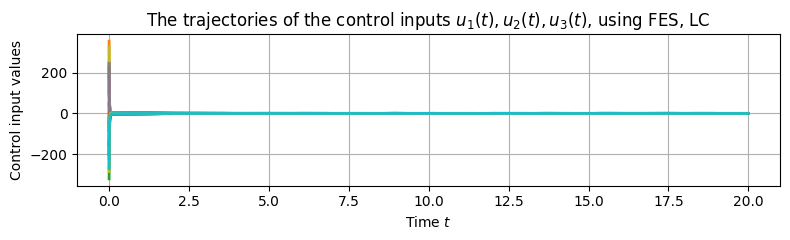

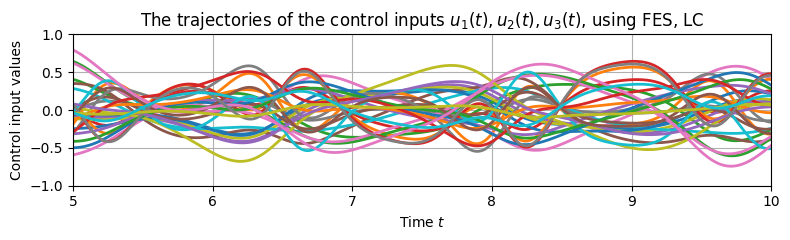

In [103]:
#Plot the input u(t)
plt.figure(figsize=(8, 2.5))
for i in range(n_nodes):
  plt.plot(T, U[i,:], linewidth=2)

plt.xlabel('Time $t$')
plt.ylabel('Control input values')
plt.title('The trajectories of the control inputs $u_1(t), u_2(t), u_{3}(t)$, using FES, LC')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 2.5))
for i in range(n_nodes):
  plt.plot(T, U[i,:], linewidth=2)

plt.xlabel('Time $t$')
plt.ylabel('Control input values')
plt.title('The trajectories of the control inputs $u_1(t), u_2(t), u_{3}(t)$, using FES, LC')
plt.grid(True)
plt.xlim(5,10)
plt.ylim(-1,1)
plt.tight_layout()
plt.show()

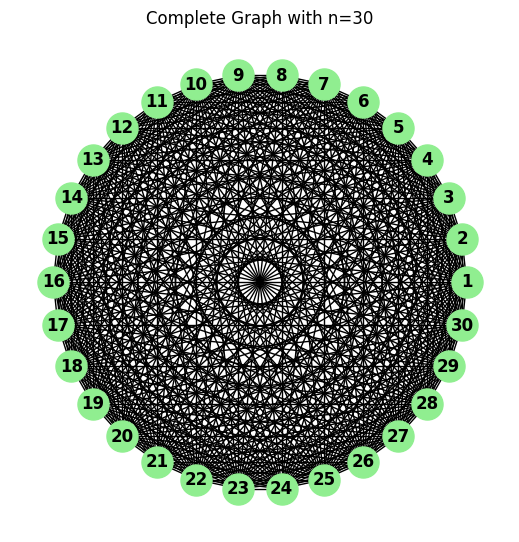

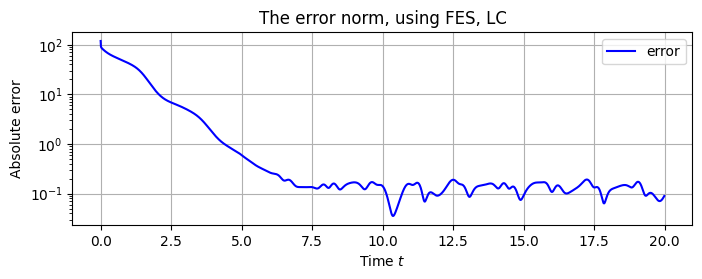

In [104]:
###Compute Error state e(t) = (Theta_c.T \otimes I_2)x(t) and its norm.
Graph_complete = nx.complete_graph(n)

mapping_complete = {i: i + 1 for i in Graph_complete.nodes()}
Graph_complete = nx.relabel_nodes(Graph_complete, mapping_complete)

pos = nx.circular_layout(Graph_complete)
plt.figure(figsize=(5, 5))
nx.draw(Graph_complete, pos, node_color='lightgreen', node_size=500, edge_color='black', with_labels=True, font_weight='bold')
plt.title(f'Complete Graph with n={n}')
plt.show()

#Create an oriented incidence matrix of the complete Graph corresponding to the above Graph.
edges_complete = []
for u, v in Graph_complete.edges():
  if u > v:
    edges_complete.append((u, v))
  else:
    edges_complete.append((v, u))

num_edges_complete = len(edges_complete)
Theta_c = np.zeros((n, num_edges_complete))

for e_idx, (u, v) in enumerate(edges_complete):
    # Subtract 1 from u and v to adjust for 0-based indexing in NumPy
    Theta_c[u - 1, e_idx] = -1
    Theta_c[v - 1, e_idx] = +1

E = np.kron(Theta_c.T, np.eye(2)) @ X  # shape: (time_steps, new_dim)
e = np.linalg.norm(E, axis=0)

###Draw the error norm
plt.figure(figsize=(8, 2.5))
plt.plot(T, e, label="error", color='blue')

plt.yscale('log')
plt.xlabel('Time $t$')
plt.ylabel('Absolute error')
plt.title('The error norm, using FES, LC')
plt.legend()
plt.grid()
plt.show()